# Using COVID19API and Alpha Vantage Data to create a market analysis

In [65]:
#Used for pulling the data
import urllib.request 
import json
#Used for formatting the data
import pandas as pd
#Used for data visualisation
import matplotlib.pyplot as plt
from matplotlib import style

In [66]:
#Returns a pandaDF of the closing stock prices in the last x amount of days
def getPriceOfStock(companySymbol, numOfDays): 
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+companySymbol+"&outputsize=full&apikey=Y11HUWNU7HM58RRL"
    json_obj = urllib.request.urlopen(url)
    #Finds the data from the url
    data = json.load(json_obj)
    #Choosing the revelant key from the data dictionary
    dates = data["Time Series (Daily)"] 
    #Initializing lists to store the data
    final_prices = [] 
    calendar = []
    counter = 0
    #For-loop used to run through every trading day 
    for day in dates: 
        counter += 1
        #Limits the amount of data using the number of days wanted
        if counter > numOfDays: 
            break
        #Gets the stock's price - This will include Open, High, Low, Closed prices
        prices = dates[day]
        #Choosing the stock's closed price
        priceNum = float(prices['4. close']) 
        final_prices.append(priceNum)
        calendar.append(day)
    #Dictionary containing the company and it's stock prices 
    final_prices.reverse()
    calendar.reverse()
    stockDict = {companySymbol : final_prices} #CHANGE
    #Formatting the pulled data to a Panda DataFrame
    df = pd.DataFrame(data = stockDict, index = pd.to_datetime(calendar))
    return df

In [67]:
#NOTE: Alpha Vantage only allows 5 API calls a minute, 500 a day -> Can only have an input size of list size 5
#Function to format (multiple) stocks into a PandaDF and alligns the dates
def bundleStockPrices(arrayOfCompanySymbols, numOfDays):
    largeTable = getPriceOfStock(arrayOfCompanySymbols[0], numOfDays) 
    del arrayOfCompanySymbols[0]
    for symbol in arrayOfCompanySymbols:
        smallTable = getPriceOfStock(symbol, numOfDays)
        #Concatenating the tables together -> will provide the intersection of all the data -> will provide <= 200 day data values
        #largeTable = pd.concat([largeTable, smallTable.reindex(largeTable.index)], axis = 1)
        largeTable = pd.concat([largeTable, smallTable], axis = 1, join ='inner')
    print("Any null data: "+str(largeTable.isnull().values.any()))
    print(largeTable.head())
    print("...")
    print(largeTable.tail())
    return largeTable

In [76]:
def plotCorrelation(title, df, chartSize):
    try:
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(chartSize,chartSize))
        ax.matshow(corr)
        #Display title
        plt.title = title
        #Display x axis with names
        plt.xticks(range(len(corr.columns)), corr.columns)
        #Display y axis with names
        plt.yticks(range(len(corr.columns)), corr.columns)
        #Display correlation graph
        plt.show()
    except:
        print("There was an error. Please check your dataframe.")

In [4]:
#libraries used
import requests
import pandas as pd
import datetime

In [59]:
##api link for get use
##https://documenter.getpostman.com/view/10808728/SzS8rjbc?version=latest

##api link for country codename
##https://documenter.getpostman.com/view/10808728/SzS8rjbc?version=latest#7934d316-f751-4914-9909-39f1901caeb8

##function for pulling new covid cases from the API

def newCasesPerDayFunc(country):
#setting variables for requests
    newCasesPerDay = []
    dateList = []
    #country = "japan" ##doesn't work for united-states, united-kingdom,
    url = "https://api.covid19api.com/country/"+country+"/status/confirmed"

    fromdate = "2020-01-01T00:00:00Z"
    todate = "2020-07-13T00:00:00Z"
    payload = {}
    headers= {}
    params = {"from":fromdate, "to":todate}

    #response and json form of response
    response = requests.request("GET", url, headers=headers, data = payload, params=params)
    dataParse = response.json()

    def dailyCasesChange(tdayCases, ydayCases):
        dailyChange = tdayCases - ydayCases
        return dailyChange

    #loop to find data we want
    listLength = len(dataParse)
    for x in range(0, listLength):
        
        #if statement: if not day 1 do the covid cases change calculation
        if x > 0:
            dailyCountryProfile = dataParse[x]
            todaysCases = dailyCountryProfile['Cases']

            ydayCountryProfile = dataParse[x-1]
            ydayCases=ydayCountryProfile['Cases']

            newCasesToday = dailyCasesChange(todaysCases, ydayCases)
            newCasesPerDay.append(newCasesToday)
                
            todaysDate = dailyCountryProfile['Date']
            dateList.append(todaysDate)
    
    countryDict = {country + " daily" : newCasesPerDay}
    df = pd.DataFrame(data = countryDict, index = pd.to_datetime(dateList))
    return df

In [83]:
def cumulativeCases(country):
    # setting variables for requests
    cumaCasesList = []
    dateList = []
    # country = "japan" ##doesn't work for united-states, united-kingdom,
    url = "https://api.covid19api.com/country/" + country + "/status/confirmed"

    fromdate = "2020-01-01T00:00:00Z"
    todate = "2020-07-13T00:00:00Z"
    payload = {}
    headers = {}
    params = {"from": fromdate, "to": todate}

    # response and json form of response
    response = requests.request("GET", url, headers=headers, data=payload, params=params)
    dataParse = response.json()

    listLength = len(dataParse)
    for x in range(0, listLength):
        dailyCountryProfile = dataParse[x]
        todaysCases = dailyCountryProfile['Cases']
        todaysDate = dailyCountryProfile['Date']
        dateList.append(todaysDate)
        cumaCasesList.append(todaysCases)
    countryDict = {country + " total" : cumaCasesList}
    df = pd.DataFrame(data = countryDict, index = pd.to_datetime(dateList))
    return df

In [61]:
def cumulativeCasesMult(listOfCountry):
    groupedTable = cumulativeCases(listOfCountry[0])
    del listOfCountry[0]
    for country in listOfCountry:
        smallTable = cumulativeCases(country)
        groupedTable = pd.concat([groupedTable, smallTable], axis = 1, join ='inner')
    print("Any null data: "+str(groupedTable.isnull().values.any()))
    print(groupedTable.head())
    print("...")
    print(groupedTable.tail())
    return groupedTable

In [62]:
def newDailyCasesMult(listOfCountry):
    groupedTable = newCasesPerDayFunc(listOfCountry[0])
    del listOfCountry[0]
    for country in listOfCountry:
        smallTable = newCasesPerDayFunc(country)
        groupedTable = pd.concat([groupedTable, smallTable], axis = 1, join ='inner')
    print("Any null data: "+str(groupedTable.isnull().values.any()))
    print(groupedTable.head())
    print("...")
    print(groupedTable.tail())
    return groupedTable

In [84]:
total_covid_cases_countries = cumulativeCasesMult(["japan","brazil","italy","south-korea"])
daily_covid_cases_countries = newDailyCasesMult(["japan","brazil","italy","south-korea"])

Any null data: False
            japan total  brazil total  italy total  south-korea total
2020-01-22            2             0            0                  1
2020-01-23            2             0            0                  1
2020-01-24            2             0            0                  2
2020-01-25            2             0            0                  2
2020-01-26            4             0            0                  3
...
            japan total  brazil total  italy total  south-korea total
2020-07-09        20617       1755779       242363              13338
2020-07-10        21044       1800827       242639              13373
2020-07-11        21430       1839850       242827              13417
2020-07-12        21841       1864681       243061              13479
2020-07-13        22125       1884967       243230              13512
Any null data: False
            japan daily  brazil daily  italy daily  south-korea daily
2020-01-23            0             0       

In [85]:
country_etf_price = bundleStockPrices(['JPXN','EWZ','EWI','EWY'],200)
country_etf_change = country_etf_price.pct_change()
country_etf_change = country_etf_change.drop(country_etf_change.index[0])
print(country_etf_change.head())

Any null data: False
               JPXN    EWZ    EWI    EWY
2019-09-30  61.1200  42.13  27.57  56.34
2019-10-01  60.6445  41.68  27.29  56.04
2019-10-02  59.9415  40.78  26.64  55.02
2019-10-03  60.2398  41.20  26.82  55.74
2019-10-04  60.9200  42.11  26.95  56.12
...
             JPXN    EWZ    EWI    EWY
2020-07-08  59.69  30.69  25.10  59.18
2020-07-09  59.35  30.46  24.41  58.82
2020-07-10  60.08  30.79  24.87  58.43
2020-07-13  59.84  30.00  24.61  58.52
2020-07-14  60.34  30.77  25.12  59.05
                JPXN       EWZ       EWI       EWY
2019-10-01 -0.007780 -0.010681 -0.010156 -0.005325
2019-10-02 -0.011592 -0.021593 -0.023818 -0.018201
2019-10-03  0.004977  0.010299  0.006757  0.013086
2019-10-04  0.011292  0.022087  0.004847  0.006817
2019-10-07 -0.003514 -0.029447  0.003711 -0.006058


In [82]:
covidTotalAndStockChange = pd.concat([country_etf_change, total_covid_cases_countries], axis=1, join='inner')
covidTotalAndStockPrice = pd.concat([country_etf_price, total_covid_cases_countries], axis=1, join='inner')
covidChangeAndStockChange = pd.concat([country_etf_change, daily_covid_cases_countries], axis=1, join='inner')
covidChangeAndStockPrice = pd.concat([country_etf_price, daily_covid_cases_countries], axis=1, join='inner')

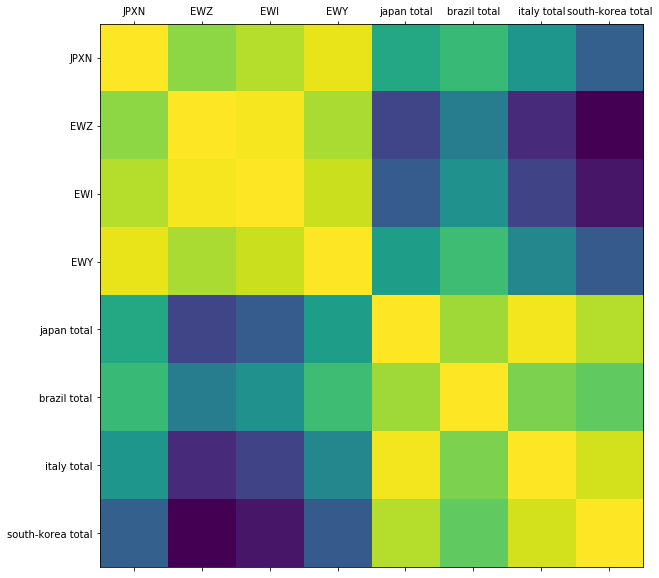

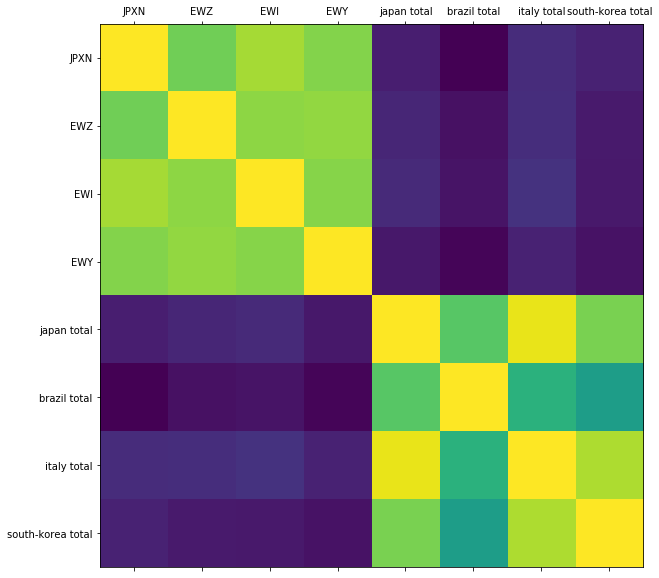

In [86]:
plotCorrelation("Covid Total against Stock Price",covidTotalAndStockPrice,10)
plotCorrelation("Covid Total against Daily Stock Price Change",covidTotalAndStockChange,10)

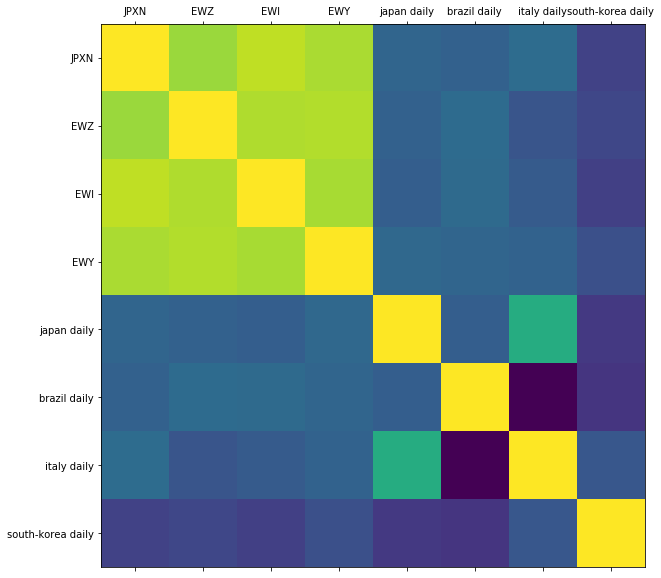

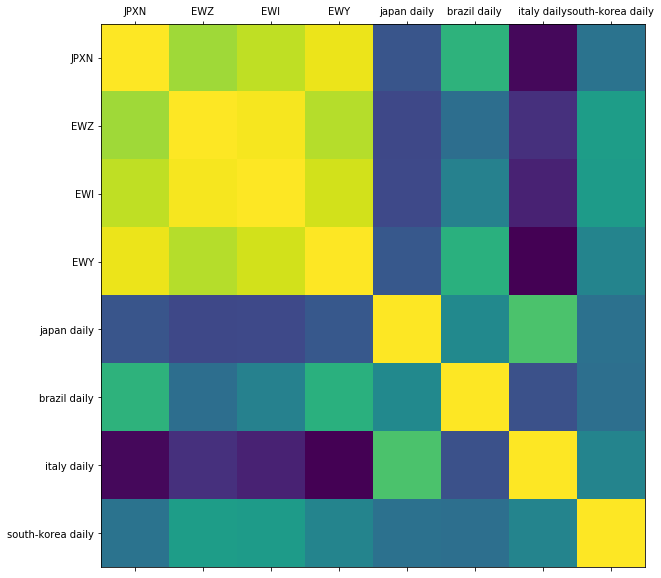

In [81]:
plotCorrelation("COVID Cases Daily against Daily Stock Price Change", covidChangeAndStockChange, 10)
plotCorrelation("COVID Cases Daily against Stock Price",covidChangeAndStockPrice,10)